In [1]:
#pip install --upgrade google-cloud-bigquery[pandas]

Requirement already up-to-date: google-cloud-bigquery[pandas] in c:\users\cjwat\anaconda3\lib\site-packages (2.16.1)


In [2]:
import os
from google.cloud import bigquery
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './google_creds.json'

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

In [3]:
client = bigquery.Client()

In [4]:
query = """
SELECT 	
	tournament
,	tournament_type
,   team_basket
,	away_name
,	home_name
,	period
,	elapsed_time_sec
,	team_name
,	event_coord_x
,	event_coord_y
,	event_type
,	shot_made
,	shot_type
,	shot_subtype
,	points_scored
,   three_point_shot


FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE event_type IN (
"twopointmade",
"threepointmade",
"twopointmiss",
"threepointmiss"
)
AND season = 2017
limit 1000000
"""

In [5]:
df = client.query(query).to_dataframe()


C:\Users\cjwat\Anaconda3\lib\site-packages\google\cloud\bigquery\client.py:462: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.api import OLS

C:\Users\cjwat\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [7]:

df = pd.get_dummies(df, columns=['shot_type'])
df = pd.get_dummies(df, columns=['shot_subtype'])
df = pd.get_dummies(df, columns=['shot_made'])
df = pd.get_dummies(df, columns=['three_point_shot'])


In [8]:

df = df.rename({
    "shot_type_jump shot":"shot_type_jump_shot",
    'shot_type_hook shot':'shot_type_hook_shot',
    'shot_type_tip shot': 'shot_type_tip_shot',
    'shot_subtype_alley-oop' : 'shot_subtype_alley_oop',
    'shot_subtype_finger roll': "shot_subtype_finger_roll",
    "shot_subtype_step back" : "shot_subtype_step_back"
},axis=1)

In [9]:
import math

# We know that the y is a measure in inches from the "top sideline"
# and x is a measure in inches from the "left baseline".
# Min/max coord values taken from dataset description in BigQuery
# We can infer that the basket is placed in the middle of the y axis on either side of the court.
basket_left = [0,300]
basket_right = [1128,300]

df['event_coords'] = df[['event_coord_x', 'event_coord_y']].values.tolist()

df['shooting_basket_location'] = [
    basket_right if x == 'right' 
    else basket_left 
    for x in df['team_basket']
]

event_coord = pd.DataFrame(df["event_coords"].tolist())
basket_coord = pd.DataFrame(df["shooting_basket_location"].tolist())

df["shot_distance"] =  np.sqrt((basket_coord[0] - event_coord[0])**2 + (basket_coord[1] - event_coord[1])**2)

In [10]:
X = df[[
     'shot_distance',
     #'points_scored',
     'three_point_shot_True',
     'shot_type_dunk',
     'shot_type_hook_shot',
     'shot_type_jump_shot',
     'shot_type_layup',
     'shot_type_tip_shot',
     'shot_subtype_alley_oop',
     'shot_subtype_driving',
     'shot_subtype_fadeaway',
     'shot_subtype_finger_roll',
     'shot_subtype_floating',
     'shot_subtype_pullup',
     'shot_subtype_putback',
     'shot_subtype_reverse',
     'shot_subtype_step_back',
     'shot_subtype_turnaround']]

y = df['shot_made_True']


In [11]:
results = OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         shot_made_True   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1562.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        13:04:35   Log-Likelihood:            -1.7594e+05
No. Observations:              261175   AIC:                         3.519e+05
Df Residuals:                  261158   BIC:                         3.521e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
shot_distance               -0.0006   1.85e-05    -32.825      0.000      -0.001      -0.001
three_point_shot_True        0.1041      0.004     29.268      0.000       0.097       0.111
shot_type_dunk               0.9046      0.005    178.453      0.000       0.895       0.915
shot_type_hook_shot          0.5131      0.007     72.028      0.000       0.499       0.527
shot_type_jump_shot          0.4400      0.004    106.347      0.000       0.432       0.448
shot_type_layup              0.5705      0.003    211.865      0.000       0.565       0.576
shot_type_tip_shot           0.6646      0.009     76.407      0.000       0.648       0.682
shot_subtype_alley_oop       0.1306      0.013      9.819      0.000       0.105       0.157
shot_subtype_driving         0.1404      0.004     33.302      0.000       0.132       0.149
shot_subtype_fadeaway        0.1178      0.012      9.430      0.000       0.093       0.142
shot_subtype_finger_roll     0.2721      0.016     17.375      0.000       0.241       0.303
shot_subtype_floating        0.1615      0.007     22.903      0.000       0.148       0.175
shot_subtype_pullup          0.2015      0.006     35.979      0.000       0.190       0.212
shot_subtype_putback         0.2285      0.008     30.274      0.000       0.214       0.243
shot_subtype_reverse         0.1823      0.011     16.524      0.000       0.161       0.204
shot_subtype_step_back       0.1682      0.011     15.843      0.000       0.147       0.189
shot_subtype_turnaround      0.1653      0.009     19.307      0.000       0.149       0.182
==============================================================================
Omnibus:                  1233090.854   Durbin-Watson:                   0.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32073.370
Skew:                           0.275   Prob(JB):                         0.00
Kurtosis:                       1.374   Cond. No.                     3.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

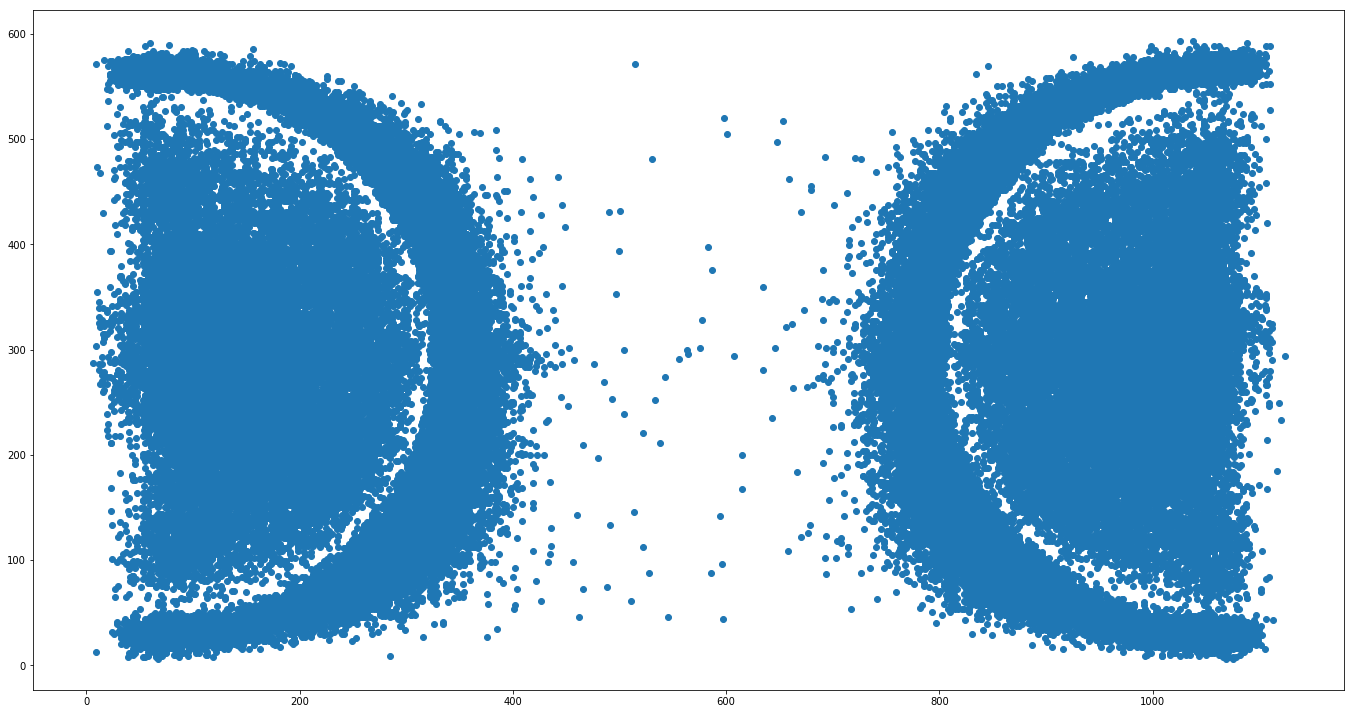

In [12]:
import matplotlib.pyplot as plt
df_made = df[df['shot_made_False'] == 1]
plt.figure(figsize=(23.5, 12.5))
plt.scatter(df_made["event_coord_x"], df_made["event_coord_y"])
plt.show()

<h1>Model Testing</h1>

<h3>Final Data Prep</h3>

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale the x,y shot coordinates
scaler = MinMaxScaler()
scaler.fit(X_train[["shot_distance"]])
X_train[["shot_distance"]] = scaler.transform(X_train[["shot_distance"]])
X_test[["shot_distance"]] = scaler.transform(X_test[["shot_distance"]])



C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_s

<h3>Random Forest Classifier</h3>

In [14]:
# Fit random forest classifier
classifier = RandomForestClassifier(n_estimators=200, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [16]:
print(classification_report(y_test,y_pred),
      "\nAccuracy:\n" + str(metrics.accuracy_score(y_test, y_pred)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred))
     )

              precision    recall  f1-score   support

           0       0.62      0.67      0.65     29070
           1       0.54      0.49      0.51     23165

   micro avg       0.59      0.59      0.59     52235
   macro avg       0.58      0.58      0.58     52235
weighted avg       0.59      0.59      0.59     52235
 
Accuracy:
0.5904853067866374 

Confusion matrix
 [[19574  9496]
 [11895 11270]]


<h3>Logistic Regression</h3>

In [17]:
lr = LogisticRegression()

result = lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [18]:
print(classification_report(y_test,y_pred_lr),
      "\nAccuracy:\n" + str(metrics.accuracy_score(y_test, y_pred_lr)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred_lr))
     )

              precision    recall  f1-score   support

           0       0.65      0.77      0.70     29070
           1       0.62      0.48      0.54     23165

   micro avg       0.64      0.64      0.64     52235
   macro avg       0.64      0.62      0.62     52235
weighted avg       0.64      0.64      0.63     52235
 
Accuracy:
0.641140997415526 

Confusion matrix
 [[22381  6689]
 [12056 11109]]


<h3>Mutilayer Percepton (Neural Network)</h3>

In [19]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())
y_pred_mlp = mlp.predict(X_test)

C:\Users\cjwat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:743: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)


In [20]:
print(classification_report(y_test,y_pred_mlp),
      "\nAccuracy:\n" + str(metrics.accuracy_score(y_test, y_pred_mlp)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred_mlp))
     )

              precision    recall  f1-score   support

           0       0.64      0.80      0.71     29070
           1       0.64      0.44      0.52     23165

   micro avg       0.64      0.64      0.64     52235
   macro avg       0.64      0.62      0.62     52235
weighted avg       0.64      0.64      0.63     52235
 
Accuracy:
0.6425768163109027 

Confusion matrix
 [[23380  5690]
 [12980 10185]]


<h3>Gradient Boost</h3>

In [21]:
#pip install xgboost
import xgboost as xgb

In [22]:
xgb_class = xgb.XGBClassifier(
    n_estimators = 1,
    max_depth = 3,
    learning_rate = 0.00001
)
xgb_class.fit(X_train,y_train)
y_pred = xgb_class.predict(X_test)
y_pred_xgb = [round(value) for value in y_pred]

C:\Users\cjwat\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
print(classification_report(y_test,y_pred_xgb),
      "\nAccuracy XGB:\n" + str(metrics.accuracy_score(y_test, y_pred_xgb)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred_xgb))
     )

              precision    recall  f1-score   support

           0       0.64      0.78      0.71     29070
           1       0.62      0.45      0.52     23165

   micro avg       0.64      0.64      0.64     52235
   macro avg       0.63      0.62      0.61     52235
weighted avg       0.63      0.64      0.63     52235
 
Accuracy XGB:
0.6363932229348138 

Confusion matrix
 [[22802  6268]
 [12725 10440]]


<h3>K-Nearest Neighbors</h3>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#pip install pandas==1.0.5 --user
#Issue with numpy and pandas communicating on current package with dtypes. Had to install specific version.

In [ ]:
# k_values = pd.DataFrame(columns=['accuracy'], dtype=np.float32)


error_rate = []

for i in range(340,351):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    error_rate.append(metrics.accuracy_score(y_test, y_pred_knn))

plt.figure(figsize=(15,10))
plt.plot(range(340,351),error_rate, marker='o', markersize=9)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=346)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test,y_pred_knn),
      "\nAccuracy XGB:\n" + str(metrics.accuracy_score(y_test, y_pred_knn)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred_knn))
     )


<h3>Support Vector Classifier</h3>

In [ ]:
from sklearn.svm import SVC
model = SVC(verbose=True)
model.fit(X_train, y_train)
y_pred_svc = model.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred_svc),
      "\nAccuracy:\n" + str(metrics.accuracy_score(y_test, y_pred_svc)),
      "\n\nConfusion matrix\n", str(confusion_matrix(y_test,y_pred_svc))
     )

In [ ]:
https://www.jphwang.com/nba-shot-data-analytics-visualization-with-python-pandas-and-matplotlib-part-2-grouping-data-by-area/

In [ ]:
X_train

In [ ]:
df